# Arbitrary line interpolation with `xarray`

First, the usual imports.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Read the seismic

**The seismic data is too big for GitHub. The easiest thing to do is to download the HDF5 file:**

-  https://s3.amazonaws.com/agilegeo/Penobscot.h5 (about 120MB)

**and put it into the `data` folder. Then you can just do this:**

In [2]:
import h5py
h5f = h5py.File('data/Penobscot.h5','r')
seismic_data = h5f['amplitude'][:]
h5f.close()

In [3]:
seismic_data.shape

(251, 601, 481)

From [the Terranubis site](https://terranubis.com/datainfo/Penobscot):

- Inline range and step: 1000, 1600, 1
- Crossline range and step: 1000, 1481, 1
- Z range and step: 0, 6, 0.004 Time
- Inline bin size (m/line): 12.5
- Crossline bin size (m/line): 25.01
- Area (sq km): 90.27

Corners, from [Moreno and Galeano 2019](file:///home/matt/Downloads/Garcia_Moreno_Omana_Galeano_2.pdf) (I have not double-checked this, eg the CRS).

| Corners | North coordinate | East coordinate |
|---------|------------------|-----------------|
| P1 | 4890130.78 | 731998.45 |
| P2 | 4896722.05 | 728527.16 |
| P3 | 4895689.47 | 742633.34 |
| P4 | 4802330.74 | 739162.05 |

Can't figure out how to do the skewed grid, so I'm going to completely invent the coordinates:

In [4]:
import xarray as xr

t, x, i = seismic_data.shape
xs = 25.0 * np.arange(i) + 100000
ys = 12.5 * np.arange(x) + 200000
tslices = np.arange(t) * 0.004

seismic = xr.DataArray(seismic_data,
                       name='Amplitude',
                       coords=[tslices, ys, xs],
                       dims=['twt', 'y', 'x'],
                       )

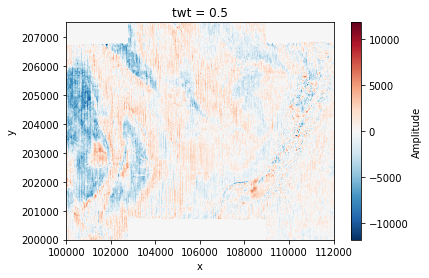

In [5]:
seismic.loc[0.500].plot()

In [6]:
del seismic_data

## Define the fence

In [7]:
from shapely.geometry import LineString

line = LineString([(101000, 207200), (106000, 200200), (111000, 207200)])

line.length

17204.650534085253

Let's see how the line looks on the seismic data:

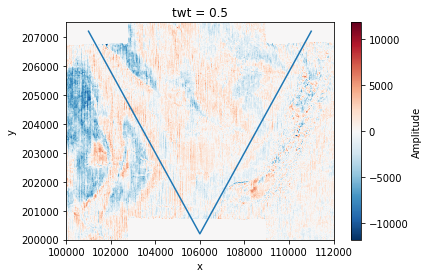

In [8]:
seismic.loc[0.500].plot()
plt.plot(*np.asarray(line.coords.xy))

Define the distance between traces.

In [9]:
trace_distance = 100
n_traces = np.ceil(line.length / trace_distance)
trace_locs = trace_distance * np.arange(n_traces + 1)
print(f"Interpolating {n_traces} traces.")

Interpolating 173.0 traces.


## Do the interpolation

In [10]:
from tqdm import tqdm

points = [line.interpolate(loc) for loc in trace_locs]

traces = np.stack([seismic.interp(x=p.x, y=p.y) for p in tqdm(points)])

100%|██████████| 174/174 [02:23<00:00,  1.25it/s]


Make a new `xarray` object:

In [11]:
arbline = xr.DataArray(traces.T,
                       name='Amplitude',
                       coords=[tslices, trace_locs],
                       dims=['twt', 'offset'],
                       )

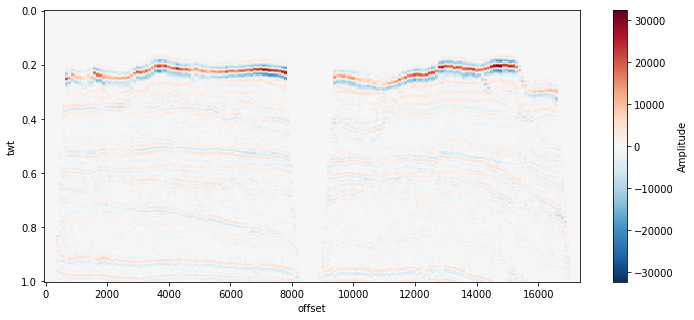

In [12]:
arbline.plot(figsize=(12, 5))
plt.gca().invert_yaxis() 

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:left;" width="50px" /><p style="color:gray; float:left; margin-left:12px;">Code and text © 2020 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;<br>Data: Penobscot, licensed CC-BY-SA, Nova Scotia Department of Energy https://opendtect.org/osr/. </p>